<a href="https://colab.research.google.com/github/VladShajdulin/OTUS/blob/main/home_work_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split

In [54]:
low, high = -10, 10
n_size = 20000

torch.manual_seed(142)
X = (high - low) * torch.rand((n_size, 2), dtype=torch.float64) + low
y = torch.sin(X[:,0] + 2 * X[:,1]) * torch.exp(-(2 * X[:,0] + X[:,1]) ** 2)
y = torch.unsqueeze(y, -1)

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=142)
# mu, std, delta = y_train.mean(), y_train.std(), 0.1
# y_train, y_test = (y_train - mu + delta) / std, (y_test - mu + delta) / std
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=142)

print(f'Training samples: {X_train.size()[0]}')
print(f'Validating samples: {X_val.size()[0]}')
print(f'Training samples: {X_test.size()[0]}')

Training samples: 14000
Validating samples: 3000
Training samples: 3000


In [56]:
class XY_dataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return self.X.size()[0]

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]

In [57]:
def train(dataloader, model, loss_fn, optimizer, device):
  size = len(dataloader.dataset)
  model.train()
  for batch, (X, y) in enumerate(dataloader):
      X, y = X.to(device), y.to(device)

      # Compute prediction error
      pred = model(X)
      loss = loss_fn(pred, y)

      # Backpropagation
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()

      if batch % 10 == 0:
          loss, current = loss.item(), (batch + 1) * len(X)
          print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def val(X, y, model, loss_fn):
  model.eval()
  with torch.no_grad():
    pred = model(X)
    loss = loss_fn(pred, y).item()
    error = max(abs(y - pred)).item()

  print(f"\n Val loss: {loss:>7f}, max error: {error:>5f} \n")

In [94]:
model_1 = nn.Sequential(
    nn.Linear(2, 20, dtype=torch.float64),
    nn.Softsign(),
    nn.Linear(20, 40, dtype=torch.float64),
    nn.LeakyReLU(),
    nn.Linear(40, 20, dtype=torch.float64),
    nn.Softsign(),
    nn.Linear(20, 10, dtype=torch.float64),
    nn.LeakyReLU(),
    nn.Linear(10, 1, dtype=torch.float64)
)

In [95]:
batch_size = 64

train_loader = XY_dataset(X_train, y_train)
train_loader = DataLoader(train_loader, shuffle=True, batch_size=batch_size)
device = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else 'cpu'
model_1.to(device)
print('Device', device)

Device cpu


In [98]:
val(X_test, y_test, model_1, nn.MSELoss())


 Val loss: 0.000480, max error: 0.360832 



In [97]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.AdamW(model_1.parameters())
epochs = 100

for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")
  train(train_loader, model_1, loss_fn, optimizer, device)
  val(X_val, y_val, model_1, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 0.136158  [   64/14000]
loss: 0.062169  [  704/14000]
loss: 0.043771  [ 1344/14000]
loss: 0.011766  [ 1984/14000]
loss: 0.028739  [ 2624/14000]
loss: 0.001967  [ 3264/14000]
loss: 0.031953  [ 3904/14000]
loss: 0.022041  [ 4544/14000]
loss: 0.048678  [ 5184/14000]
loss: 0.019483  [ 5824/14000]
loss: 0.012532  [ 6464/14000]
loss: 0.016587  [ 7104/14000]
loss: 0.029465  [ 7744/14000]
loss: 0.009955  [ 8384/14000]
loss: 0.024343  [ 9024/14000]
loss: 0.022926  [ 9664/14000]
loss: 0.002676  [10304/14000]
loss: 0.010714  [10944/14000]
loss: 0.047814  [11584/14000]
loss: 0.016833  [12224/14000]
loss: 0.033968  [12864/14000]
loss: 0.007910  [13504/14000]

 Val loss: 0.015746, max error: 1.020369 

Epoch 2
-------------------------------
loss: 0.021550  [   64/14000]
loss: 0.016163  [  704/14000]
loss: 0.000297  [ 1344/14000]
loss: 0.001162  [ 1984/14000]
loss: 0.000721  [ 2624/14000]
loss: 0.006434  [ 3264/14000]
loss: 0.034721  [ 3904/14000]
loss: 

In [68]:
import numpy as np

x = np.linspace(-10, 10, 100)
y = np.linspace(-10, 10, 100)
X, Y = np.meshgrid(x, y)
X, Y = torch.from_numpy(X), torch.from_numpy(Y)

In [69]:
X_grid = torch.stack([X, Y], dim=-1)
X_grid.size()

torch.Size([100, 100, 2])

In [99]:
z = model_1(X_grid).detach().numpy()
z = np.squeeze(z)
z.shape

(100, 100)

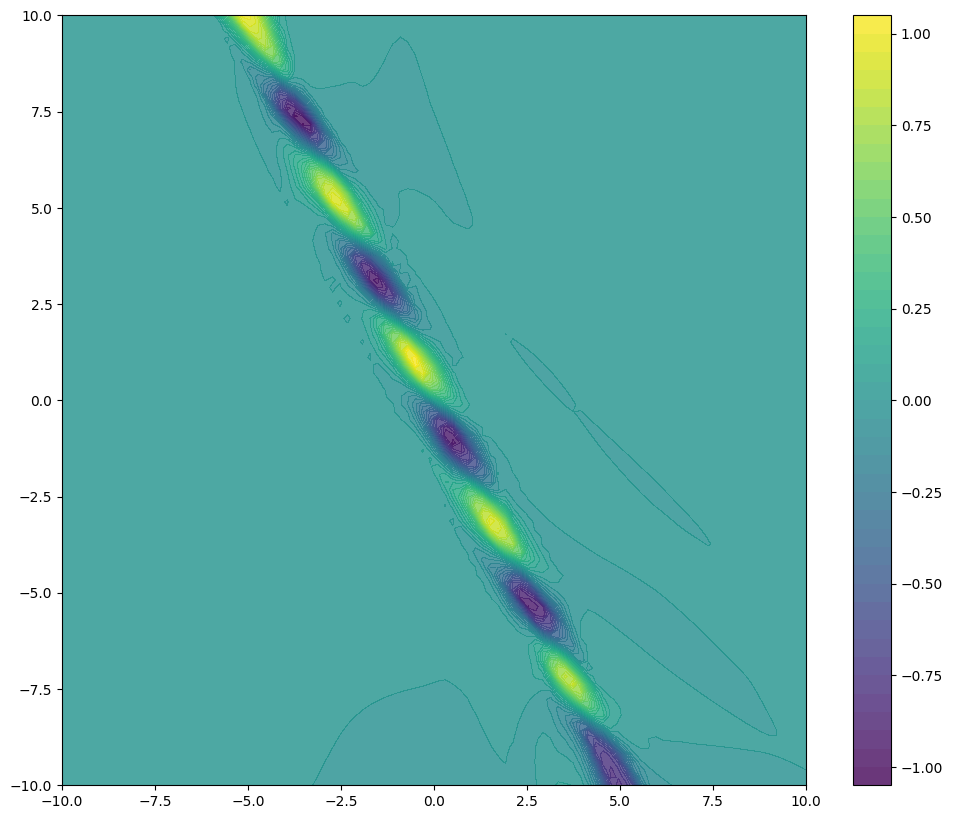

In [100]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 10))
plt.contourf(X, Y, z, 50, alpha=0.8, cmap='viridis')
plt.colorbar()

/tmp/ipython-input-809764902.py:1: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z = np.sin(X + 2 * Y) * np.exp(-(2 * X + Y) ** 2)


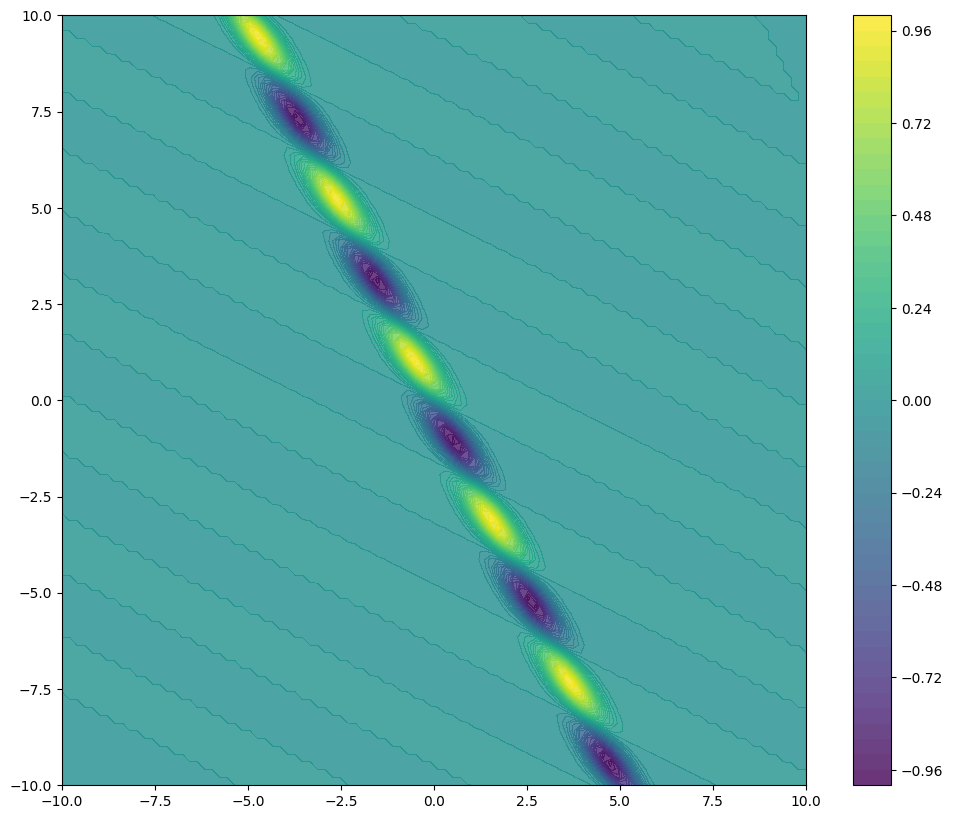

In [ ]:
z = np.sin(X + 2 * Y) * np.exp(-(2 * X + Y) ** 2)

plt.figure(figsize=(12, 10))
plt.contourf(X, Y, z, 50, alpha=0.8, cmap='viridis')
plt.colorbar()